# Index

### Table of Contents

Input index here once all sections are finalised!

# Introduction

 * What is the Project
 * Why is it important
 * How will we go about doing it

In this twenty first century the internet has become an important part of human life, however there is the downside and upside of the situation. The downside is that users are presented with numerous choices of products such as real estate, investment options and movie products, among others. To help users cope with this information explosion, companies have deployed recommendation systems to guide their users. The interest in development of recommendation systems remains high because of the abundance of practical applications and the problem rich domain. Several such online recommendation systems implemented and used include movie Recommender Systems. Movie Recommender Systems have significantly contributed to the economy of organisations such as Netflix which have made these systems a salient part of their websites. For example, Netflix, 2/3rd of the movies watched are recommended .To this end JS3 team saw the need to develop a movie recommender system. That can be deployed by movie houses to enhance their profitability.

# PROBLEM STATEMENT 

Due to information explosion , the need to build relationships between products and users to enhance the probability of a specific user selecting the most appropriate product is escalating. As a result recommender systems are increasingly sought after for this objective to be realised.

# Data size and structure

The Data's size and structure 

# Load Dependencies

In [76]:
# Install packages here
# Packages for data processing
import numpy as np
import pandas as pd
import datetime
from sklearn import preprocessing
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import re
from scipy.sparse import csr_matrix
import scipy as sp


# Packages for visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Packages for modeling
from surprise import Reader
from surprise import Dataset
from surprise import KNNWithMeans
from surprise import KNNBasic
from surprise.model_selection import train_test_split
from surprise.model_selection import cross_validate
from surprise.model_selection import GridSearchCV
from surprise import SVD
from surprise import SVDpp
from surprise import NMF
from surprise import SlopeOne
from surprise import CoClustering
from sklearn.feature_extraction.text import CountVectorizer
import heapq

#wod cloud
from PIL import Image
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import seaborn as sns

# Packages for model evaluation
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from time import time

# Package to suppress warnings
import warnings
warnings.filterwarnings("ignore")

# Packages for saving models
import pickle

# Data Collection

In [2]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
df_sample_submission = pd.read_csv('sample_submission.csv')
df_movies = pd.read_csv('movies.csv')
df_imdb = pd.read_csv('imdb_data.csv')
df_genome_scores = pd.read_csv('genome_scores.csv')
df_genome_tags = pd.read_csv('genome_tags.csv')
df_tags = pd.read_csv('tags.csv')
df_links = pd.read_csv('links.csv')

#### View the dataframes loaded

## Genome scores and tags

In [27]:
df_genome_scores.head(2)

,movieId,tagId,relevance
0,1,1,0.02875
1,1,2,0.02375


In [28]:
# check length 
len(df_genome_scores)

15584448

In [29]:
df_genome_tags.head(2)

,tagId,tag
0,1,007
1,2,007 (series)


In [30]:
len(df_genome_tags)

1128

In [31]:
len(df_genome_tags)

1128

# IMDB data

In [33]:
df_imdb.head(2)

,movieId,title_cast,director,runtime,budget,plot_keywords
0,1,Tom Hanks|Tim Allen|Don Rickles|Jim Varney|Wal...,John Lasseter,81.0,"$30,000,000",toy|rivalry|cowboy|cgi animation
1,2,Robin Williams|Jonathan Hyde|Kirsten Dunst|Bra...,Jonathan Hensleigh,104.0,"$65,000,000",board game|adventurer|fight|game


In [34]:
len(df_imdb['movieId'])

27278

## Links and Movies

In [35]:
df_links.head(2)

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0


In [36]:
len(df_links['movieId'])

62423

In [37]:
df_movies.head(2)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy


In [38]:
len(df_movies['movieId'])

62423

## Tags

In [39]:
df_tags.head(2)

,userId,movieId,tag,timestamp
0,3,260,classic,1439472355
1,3,260,sci-fi,1439472256


In [40]:
len(df_tags['movieId'])

1093360

# Train and test

In [41]:
df_train.head(2)

,userId,movieId,rating,timestamp
0,5163,57669,4.0,1518349992
1,106343,5,4.5,1206238739


In [43]:
len(df_train)

10000038

# Data Preprocessing

## Checking for Missing Values

Kaggle tries to provide us with clean data but it's always a good idea to check for ourselves. We check for null and empty values.

In [7]:
df_train.isnull().sum()

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

In [8]:
i=0
for x in df_train.columns:
    if '' in sorted(df_train[x].unique()):
        i+=1
print('The data contains '+str(i)+' empty values over all columns')

The data contains 0 empty values over all columns


The data contains 0 empty values over all columns None of our columns contain any null or empty values.

## Checking for Duplicate Values

Checking for duplicate values in the dataset using the .duplicated which returns a boolean Series denoting duplicate rows

In [9]:
# Store dDuplications
val_bool = df_train.duplicated(['userId', 'movieId', 'rating'])

# Show Duplications
print("Number of duplicated values:", sum(val_bool))


Number of duplicated values: 0


Our data has no duplicates

## Length of Unique Values

In [10]:
print("Number of unique userID values :",len(df_train['userId'].unique()),
      "\nNumber of unique movieId values :",len(df_train['movieId'].unique()))
#, )

Number of unique userID values : 162541 
Number of unique movieId values : 48213


In [11]:
len(df_movies['movieId'].unique())

62423

## Exploratory Data Anaylsis

Most common Genres

In [12]:
# Create dataframe containing only the movieId and genres
movies_genres = pd.DataFrame(df_movies[['movieId', 'genres']],
                             columns=['movieId', 'genres'])

# Split genres seperated by "|" and create a list containing the genres allocated to each movie
movies_genres.genres = movies_genres.genres.apply(lambda x: x.split('|'))

# Create expanded dataframe where each movie-genre combination is in a seperate row
movies_genres = pd.DataFrame([(tup.movieId, d) for tup in movies_genres.itertuples() for d in tup.genres],
                             columns=['movieId', 'genres'])

movies_genres.head()

,movieId,genres
0,1,Adventure
1,1,Animation
2,1,Children
3,1,Comedy
4,1,Fantasy


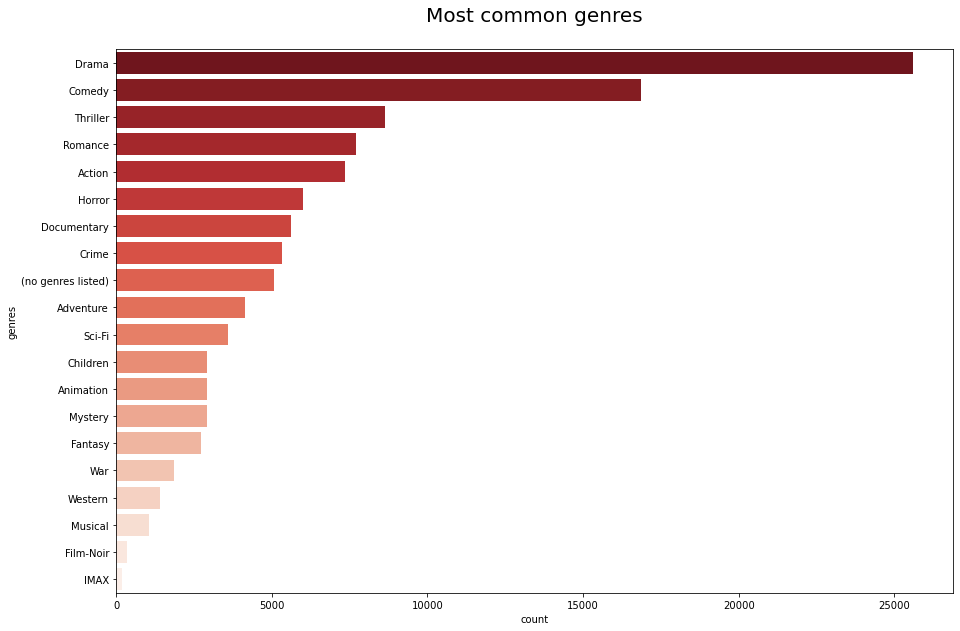

In [13]:
# Plot the genres from most common to least common
plot = plt.figure(figsize=(15, 10))
plt.title('Most common genres\n', fontsize=20)
sns.countplot(y="genres", data=movies_genres,
              order=movies_genres['genres'].value_counts(ascending=False).index,
              palette='Reds_r')
plt.show()

Drama is the leading genre in our dataset.Drama is often serious stories based on incidents that occur on a regular basis in ordinary life. These films depict genuine persons who are at odds with themselves, others, or natural forces. They mainly concentrate on the characters and how they develop through time. Because most movies shows rely on character-driven storytelling to keep audiences engaged, drama is frequently mixed with other genres.Comedy continues to be one of the most popular film genres. It is a popular film genre among both youngsters and adults since these films have the ability to make an entire audience laugh and smile.


## Merge train with movies

In [45]:
train_movies = pd.merge(df_train, df_movies, on='movieId')
train_movies.head(2)

,userId,movieId,rating,timestamp,title,genres
0,5163,57669,4.0,1518349992,In Bruges (2008),Comedy|Crime|Drama|Thriller
1,87388,57669,3.5,1237455297,In Bruges (2008),Comedy|Crime|Drama|Thriller


In [46]:
# check the length of train_movies
len(train_movies)
# check for null values
train_movies.isnull().sum()

userId       0
movieId      0
rating       0
timestamp    0
title        0
genres       0
dtype: int64

there is no null values to we can go further

In [47]:
# display last 5 rows of train_movies
train_movies.tail(3)

,userId,movieId,rating,timestamp,title,genres
10000035,131116,206347,3.0,1568558126,Nocturne (1946),Crime|Drama|Mystery
10000036,85757,196867,3.5,1563175258,Guys & Balls (2004),Comedy|Romance
10000037,72315,97148,3.0,1567584197,Elia Kazan: A Director's Journey (1995),Documentary


In [48]:
# top 20 movies based on their ratings
train_movies.groupby('title')['rating'].mean().sort_values(ascending=False).head(20)

title
Which Way Home (2009)                                       5.0
Kaakha Kaakha (2003)                                        5.0
Not Quite Human II (1989)                                   5.0
Selling Isobel (2018)                                       5.0
Sehar (2005)                                                5.0
The Enchanted Sedan Chair (1905)                            5.0
K.G.F: Chapter 1 (2018)                                     5.0
Hard Cash (2002)                                            5.0
Everyone's Going to Die (2013)                              5.0
Anything for Love (2016)                                    5.0
Chain of Command (2015)                                     5.0
A Killing in a Small Town (1990)                            5.0
Political Animals (2016)                                    5.0
Kabir Singh (2019)                                          5.0
Everything Is Terrible! Presents: The Great Satan (2017)    5.0
Yamadonga (2007)                  

In [49]:
# Top 20 movies that were rated the most
train_movies.groupby('title')['rating'].count().sort_values(ascending=False).head(20)

title
Shawshank Redemption, The (1994)                                                  32831
Forrest Gump (1994)                                                               32383
Pulp Fiction (1994)                                                               31697
Silence of the Lambs, The (1991)                                                  29444
Matrix, The (1999)                                                                29014
Star Wars: Episode IV - A New Hope (1977)                                         27560
Jurassic Park (1993)                                                              25518
Schindler's List (1993)                                                           24004
Braveheart (1995)                                                                 23722
Fight Club (1999)                                                                 23536
Terminator 2: Judgment Day (1991)                                                 23075
Toy Story (1995)          

In [50]:
#create a dataframe for analysis
num_of_ratings = pd.DataFrame(train_movies.groupby('title')['rating'].mean().sort_values(ascending=False))
num_of_ratings['total number of ratings'] = pd.DataFrame(train_movies.groupby('title')['rating'].count()) 

In [51]:
num_of_ratings.head(2)

,rating,total number of ratings
title,,
Which Way Home (2009),5.0,1
Kaakha Kaakha (2003),5.0,1


Let's create a new dataframe also containing the `title`, `rating` and `total number of ratings`, but this time we will sort by the `total number of ratings`.

In [53]:
#create a dataframe for analysis
new_trend = pd.DataFrame(train_movies.groupby('title')['rating'].mean())
new_trend['total number of ratings'] = pd.DataFrame(train_movies.groupby('title')['rating'].count())
num_of_ratings.head(2)

,rating,total number of ratings
title,,
Which Way Home (2009),5.0,1
Kaakha Kaakha (2003),5.0,1


Let's create a new dataframe also containing the `title`, `rating` and `total number of ratings`, but this time we will sort by the `total number of ratings`.

In [54]:
#create a dataframe for analysis
new_trend = pd.DataFrame(train_movies.groupby('title')['rating'].mean())
new_trend['total number of ratings'] = pd.DataFrame(train_movies.groupby('title')['rating'].count())
# sort dataframe by total number of ratings
new_trend.sort_values(by=['total number of ratings'], inplace=True, ascending=False)
# reset the index
new_trend.reset_index(inplace=True)
new_trend.head(3)

,title,rating,total number of ratings
0,"Shawshank Redemption, The (1994)",4.417624,32831
1,Forrest Gump (1994),4.047216,32383
2,Pulp Fiction (1994),4.195097,31697


Text(0.5, 1.0, 'Distribution of Ratings')

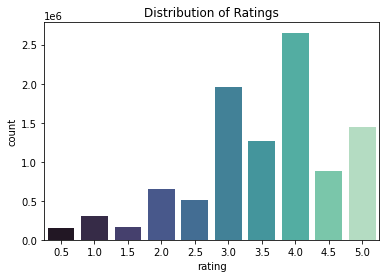

In [55]:
# plot distribution of ratings
sns.countplot(x = 'rating', data = train_movies, palette="mako")
plt.title("Distribution of Ratings")

The graph above depicts the distribution of ratings across our dataset with 4.0 being the greatest and 0.5 being the lowest.

In [56]:
#create a dataframe for analysis
user_id = pd.DataFrame(train_movies.groupby('userId')['rating'].mean())
user_id['total number of ratings'] = pd.DataFrame(train_movies.groupby('userId')['rating'].count())
user_id.head(2)

,rating,total number of ratings
userId,,
1,3.910714,28
2,3.416667,72


(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, '72315'),
  Text(1, 0, '80974'),
  Text(2, 0, '137293'),
  Text(3, 0, '33844'),
  Text(4, 0, '20055'),
  Text(5, 0, '109731'),
  Text(6, 0, '49403'),
  Text(7, 0, '92046'),
  Text(8, 0, '110971'),
  Text(9, 0, '30879')])

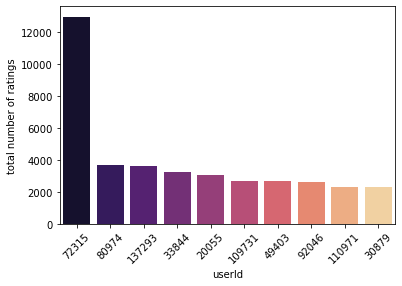

In [57]:
# sort dataframe by total number of ratings
user_id.sort_values(by=['total number of ratings'], inplace=True, ascending=False)
# reset the index
user_id.reset_index(inplace=True)
#total number of ratings per user id
sns.barplot(y="total number of ratings", x="userId", data=user_id.head(10), 
            order = user_id.head(10).sort_values('total number of ratings', ascending=False).userId, palette='magma')
plt.xticks(rotation=45)

A large number of users may be reviewing and rating specific movies. While the other movies may be rated by as few as one user. In such cases, some less popular films may be added to the recommendation list, while others may be excluded.

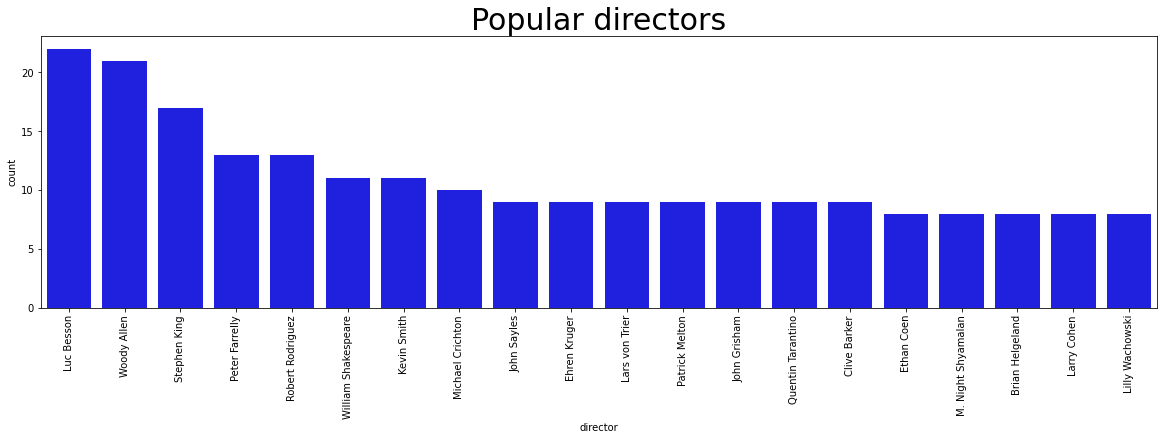

In [60]:
df_imdb.dropna(inplace=True)

# Plot popular directors
plt.figure(figsize = (20,5))
directors=df_imdb['director'].explode()
ax=sns.countplot(x=directors, order = directors.value_counts().index[:20],color='blue')
ax.set_title('Popular directors',fontsize=30)
plt.xticks(rotation=90)
plt.show()

Viewers take into account the film's director, and if they have previously appreciated a film made by that director, they are more likely to watch another film directed by that director.When we look at the top directors, we can find names like Luc Besson, who has previously won awards for best director,Stephen King who directed the film Shawshank Redemption which, is one of the movies within our dataset that has the most ratings.

In [61]:
#create a dataframe for analysis
ratings_trend = pd.DataFrame(train_movies.groupby('movieId')['rating'].mean())
ratings_trend['total number of ratings'] = pd.DataFrame(train_movies.groupby('movieId')['rating'].count()) 
ratings_trend.head(5)

,rating,total number of ratings
movieId,,
1,3.889971,23062
2,3.263414,9654
3,3.132325,4727
4,2.878099,968
5,3.059165,4648


<AxesSubplot:xlabel='total number of ratings', ylabel='title'>

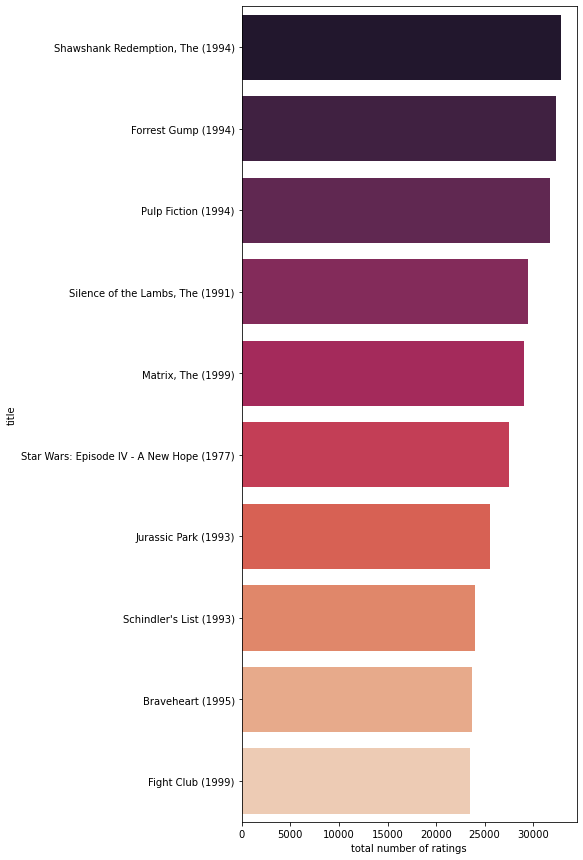

In [62]:
#create a dataframe for analysis
new_trend = pd.DataFrame(train_movies.groupby('title')['rating'].mean())
new_trend['total number of ratings'] = pd.DataFrame(train_movies.groupby('title')['rating'].count())

# sort dataframe by total number of ratings
new_trend.sort_values(by=['total number of ratings'], inplace=True, ascending=False)
# reset the index
new_trend.reset_index(inplace=True)

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(6, 15))

sns.barplot(x="total number of ratings", y="title", data=new_trend.head(10), palette='rocket')



We look at the films with the highest total number of ratings. The overall number of ratings is determined by the number of movies that have been watched and rated. We see that some of the rated films are among those that we have seen and probably appreciated.

In [65]:
# Create dataframe containing only the movieId and keywords
imdb_keywords = pd.DataFrame(df_imdb[['movieId', 'plot_keywords']],
                             columns=['movieId', 'plot_keywords'])

# Split genres seperated by "|" and create a list containing the genres allocated to each movie
imdb_keywords.plot_keywords = imdb_keywords.plot_keywords.apply(lambda x: x.split('|'))

# Create expanded dataframe where each movie-genre combination is in a seperate row
imdb_keywords = pd.DataFrame([(tup.movieId,d) for tup in imdb_keywords.itertuples() for d in tup.plot_keywords],
                             columns=['movieId', 'plot_keywords'])

imdb_keywords.head(2)

,movieId,plot_keywords
0,1,toy
1,1,rivalry


In [67]:
# Create dataframe containing only the movieId and title_casts
imdb_casts = pd.DataFrame(df_imdb[['movieId', 'title_cast']],
                             columns=['movieId', 'title_cast'])

# Split title_casts seperated by "|" and create a list containing the title_cast allocated to each movie
imdb_casts.title_cast = imdb_casts.title_cast.apply(lambda x: x.split('|'))

# Create expanded dataframe where each movie-title_cast combination is in a seperate row
imdb_casts = pd.DataFrame([(tup.movieId, d) for tup in imdb_casts.itertuples() for d in tup.title_cast],
                             columns=['movieId', 'title_cast'])

imdb_casts.head(2)

,movieId,title_cast
0,1,Tom Hanks
1,1,Tim Allen


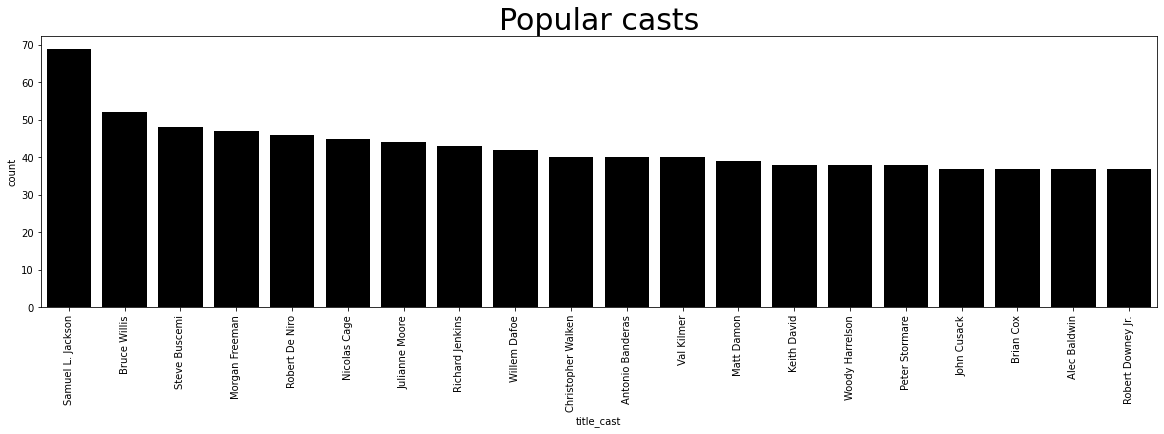

In [68]:
# Plot popular casts
plt.figure(figsize = (20,5))
casts=imdb_casts['title_cast'].explode()
ax=sns.countplot(x=casts, order = casts.value_counts().index[:20],color='black')
ax.set_title('Popular casts',fontsize=30)
plt.xticks(rotation=90)
plt.show()

When we look at the top three most popular casts, we can see that they are all well-known performers. People frequently prefer to see films starring performers they are familiar with. Movies starring well-known actors typically receive higher ratings than films starring unknown actors. Actors such as Samuel L Jackson, Morgan Freeman, and Brian Cox have all received major accolades in the past.They've appeared in some of the best films we've seen throughout the years. They've also been in the sector for quite some time.

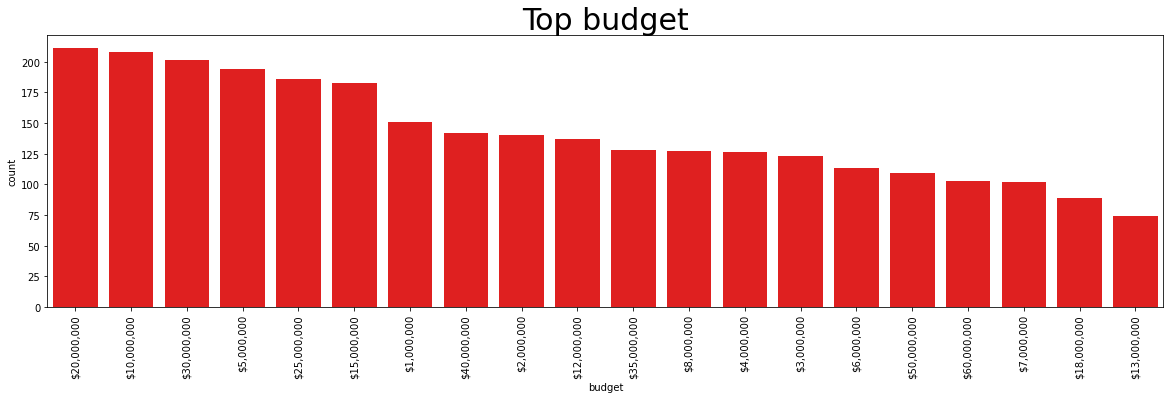

In [70]:
#budget
plt.figure(figsize = (20,5))
budget=df_imdb['budget'].explode()
ax=sns.countplot(x=budget, order = budget.value_counts().index[:20],color='red')
ax.set_title('Top budget',fontsize=30)
plt.xticks(rotation=90)
plt.show()

The budget of a film is important throughout its life cycle, having repercussions that go far beyond the film's fundamental cost. With a large budget, it's easier to go all out with the film, such as using a lot of visual effects. A large amount of marketing may be done for a high-budget film in compared to a low-budget film, which is why, despite having poorer stories, they are more popular.Our top budget is $20,000,000,the budget helps to fund the film's marketing, which in turn helps to influence who will watch the film, potentially leading to a higher rating.

<AxesSubplot:>

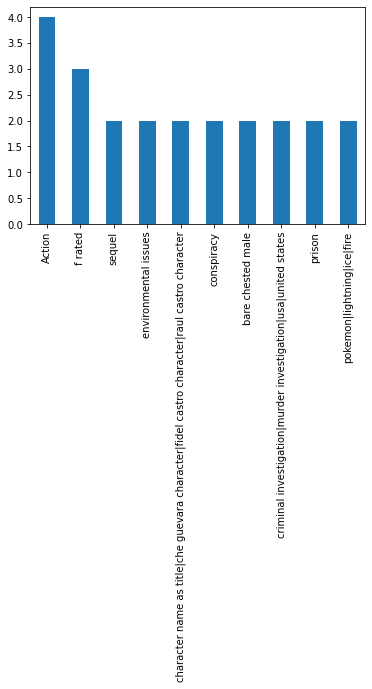

In [71]:
df_imdb['plot_keywords'].value_counts()[:10].plot(kind='bar')

The Internet Movie Database, or IMDB, is a website that contains virtually every detail on every single film that has ever been released. The only issue is that the IMDB search engine is really basic. You can seek up an actor, director, or production firm, but you'll have to scroll through their page and sift through their filmography to find the one you want.Here we are able to see the top plotkeywords that people normally search for to look at the movies they want.We are able to see action being one of the most frequent words and action movies are among one of the top 5 most common genres

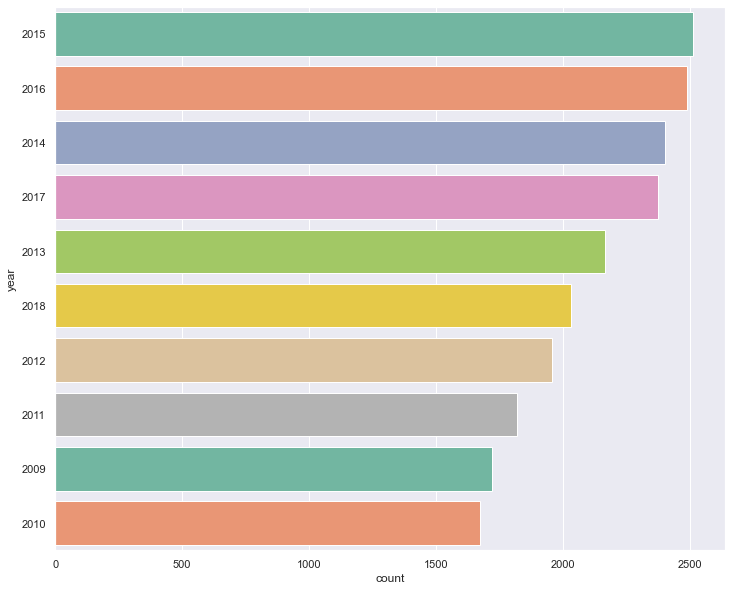

In [72]:
movies['y'] = movies['title'].str.split(' ')
movies['year'] = movies['y'].apply(lambda x: x[-1])
movies['year'] = movies['year'].str.strip(')')
movies['year'] = movies['year'].str.strip('(')
# lets drop the unnecessary 'y' column from the dataset
movies = movies.drop(['y'], axis = 1)
plt.figure(figsize=(12,10))
sns.set(style="darkgrid")
ax = sns.countplot(y="year", data=movies, palette="Set2", order=movies['year'].value_counts().index[0:10])

We can see that the year 2015 has the most films in our dataset, closely followed by 2016. We can see that the number of movies released each year has decreased during the last five years. From just over 2500 films in 2015 to just over 2000 in 2018, the number of films has steadily decreased.

<AxesSubplot:xlabel='runtime', ylabel='Density'>

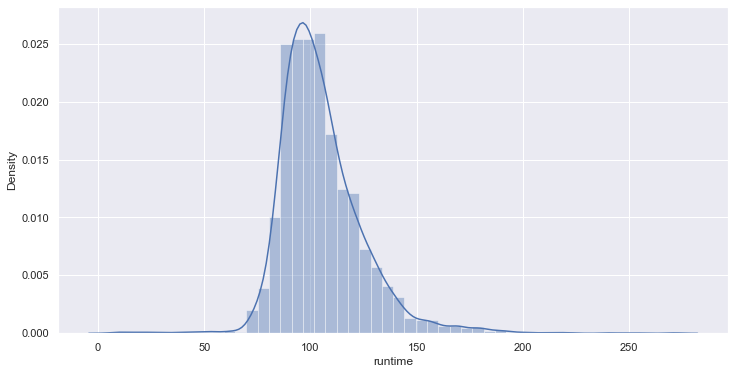

In [74]:
data = pd.merge(movies, df_imdb, on = 'movieId', how = 'inner')

##As we do not Require the MovieId, title_cast, director and plot_keywords lets remove them
data = data.drop(['movieId', 'title_cast', 'director','plot_keywords'], axis = 1)

       
plt.figure(figsize=(12,6))
sns.distplot(data[(data['runtime'] < 300) & (data['runtime'] > 0)]['runtime'])                               

So, a good amount of movies are among the duration of 90-120 mins.It is approximately the maximum time in which a large majority of the viewers can sit without going to the toilet and without drinking. It is acceptable considering the fact that a fair amount of the audience cannot watch a 3 hour movie in one sitting.

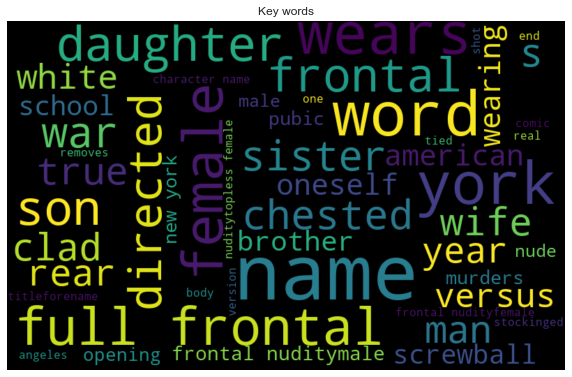

In [77]:
#word cloud for key words that people use while searching
all_words = ''.join([label for label in imdb_keywords['plot_keywords']])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110, max_words=50).generate(all_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Key words')

plt.show()

We can see the keywords people use to find the movies they want to see; for example, we see names like female, which could indicate that people are looking for films with female characters.

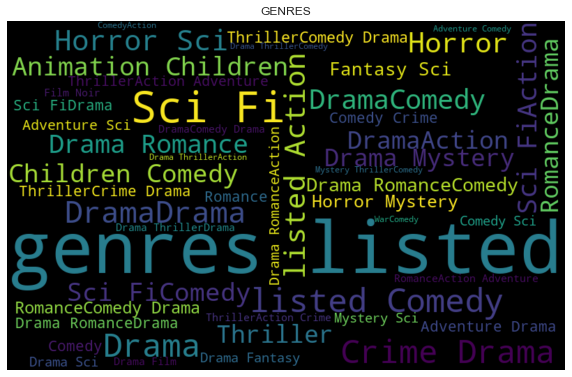

In [79]:
#word cloud for genre

all_words = ''.join([label for label in movies['genres']])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110, max_words=50).generate(all_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('GENRES')

plt.show()

We create a visual representation of the various genres that we can find in our data collection. Drama appears frequently, indicating that people are continually looking for films with some drama; they are highly recommended because the market is divided among different generations.

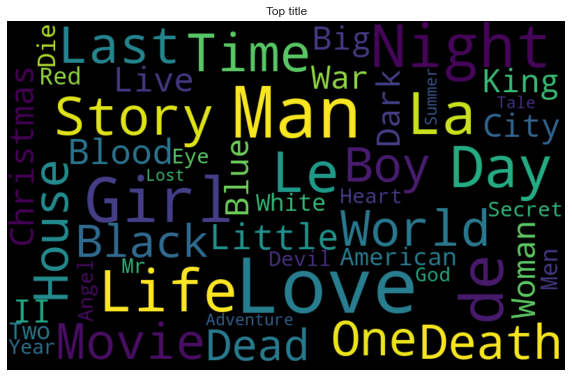

In [80]:
#word cloud for top title
from wordcloud import WordCloud
all_words = ''.join([label for label in movies['title']])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110, max_words=50).generate(all_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Top title')

plt.show()

# Filtering Methods

## Content Based Filtering

In [14]:
# Create a copy of a dataframe
movies = df_movies.copy()

In [15]:
# Merge two dataframes
df_1 = df_imdb[['movieId','title_cast','director', 'plot_keywords']]
df_1 = df_1.merge(movies[['movieId', 'genres', 'title']], on='movieId', how='inner')
df_1.head()

,movieId,title_cast,director,plot_keywords,genres,title
0,1,Tom Hanks|Tim Allen|Don Rickles|Jim Varney|Wal...,John Lasseter,toy|rivalry|cowboy|cgi animation,Adventure|Animation|Children|Comedy|Fantasy,Toy Story (1995)
1,2,Robin Williams|Jonathan Hyde|Kirsten Dunst|Bra...,Jonathan Hensleigh,board game|adventurer|fight|game,Adventure|Children|Fantasy,Jumanji (1995)
2,3,Walter Matthau|Jack Lemmon|Sophia Loren|Ann-Ma...,Mark Steven Johnson,boat|lake|neighbor|rivalry,Comedy|Romance,Grumpier Old Men (1995)
3,4,Whitney Houston|Angela Bassett|Loretta Devine|...,Terry McMillan,black american|husband wife relationship|betra...,Comedy|Drama|Romance,Waiting to Exhale (1995)
4,5,Steve Martin|Diane Keaton|Martin Short|Kimberl...,Albert Hackett,fatherhood|doberman|dog|mansion,Comedy,Father of the Bride Part II (1995)


In [16]:
# Convert data types to strings for string handling
df_1['title_cast'] = df_1.title_cast.astype(str)
df_1['plot_keywords'] = df_1.plot_keywords.astype(str)
df_1['genres'] = df_1.genres.astype(str)
df_1['director'] = df_1.director.astype(str)

# Removing spaces between names
df_1['director'] = df_1['director'].apply(lambda x: "".join(x.lower() for x in x.split()))
df_1['title_cast'] = df_1['title_cast'].apply(lambda x: "".join(x.lower() for x in x.split()))

# Discarding the pipes between the actors' full names and getting only the first three names
df_1['title_cast'] = df_1['title_cast'].map(lambda x: x.split('|'))

# Discarding the pipes between the plot keywords' and getting only the first five words
df_1['plot_keywords'] = df_1['plot_keywords'].map(lambda x: x.split('|'))
df_1['plot_keywords'] = df_1['plot_keywords'].apply(lambda x: " ".join(x))

# Discarding the pipes between the genres 
df_1['genres'] = df_1['genres'].map(lambda x: x.lower().split('|'))
df_1['genres'] = df_1['genres'].apply(lambda x: " ".join(x))

df_1.head()

,movieId,title_cast,director,plot_keywords,genres,title
0,1,"[tomhanks, timallen, donrickles, jimvarney, wa...",johnlasseter,toy rivalry cowboy cgi animation,adventure animation children comedy fantasy,Toy Story (1995)
1,2,"[robinwilliams, jonathanhyde, kirstendunst, br...",jonathanhensleigh,board game adventurer fight game,adventure children fantasy,Jumanji (1995)
2,3,"[waltermatthau, jacklemmon, sophialoren, ann-m...",markstevenjohnson,boat lake neighbor rivalry,comedy romance,Grumpier Old Men (1995)
3,4,"[whitneyhouston, angelabassett, lorettadevine,...",terrymcmillan,black american husband wife relationship betra...,comedy drama romance,Waiting to Exhale (1995)
4,5,"[stevemartin, dianekeaton, martinshort, kimber...",alberthackett,fatherhood doberman dog mansion,comedy,Father of the Bride Part II (1995)


In [17]:
#we convert the tille_cast column from list to string
df_1['liststring'] = df_1['title_cast'].apply(lambda x: ','.join(map(str, x)))

#we remove the commas between the string in each row
df_1['liststring'] = df_1['liststring'].replace(',',' ', regex=True)

#we choose keywords, cast(liststring), diector and genres column to use as our features
df_features = df_1[['liststring','director','plot_keywords','genres']]

#we combine the features columns into  single string
df_1['combined_features'] = df_features['liststring'] +' '+ df_features['director'] +' '+ df_features['plot_keywords'] +' '+ df_features['genres']

#we now feed the combined features to a CountVectorizer() object for getting the cv matrix.
cv =CountVectorizer()
cv_matrix = cv.fit_transform(df_1['combined_features'])

#now we obtain the cosine similarity matrix from the cv matrix
sim_score = cosine_similarity(cv_matrix,cv_matrix)

df_1.set_index('title', inplace = True)
indices = pd.Series(df_1.index)

In [18]:
print(sim_score)

[[1.         0.10910895 0.07715167 ... 0.03026138 0.         0.07881104]
 [0.10910895 1.         0.         ... 0.06163336 0.         0.08025724]
 [0.07715167 0.         1.         ... 0.         0.         0.        ]
 ...
 [0.03026138 0.06163336 0.         ... 1.         0.         0.03338903]
 [0.         0.         0.         ... 0.         1.         0.        ]
 [0.07881104 0.08025724 0.         ... 0.03338903 0.         1.        ]]


In [19]:
# This method will make n recommendations based off the movie title input
def content_filter(title,n,sim_score = sim_score):
    movies_recommend = []
    
    # Index of the movie that matches the title
    idx = indices[indices == title].index[0]

    # Series with the similarity scores in descending order
    score_series = pd.Series(sim_score[idx]).sort_values(ascending = False)

    # getting the indexes of the 10 most similar movies
    top_n_indexes = list(score_series.iloc[1:n+1].index)
    
    # populating the list with the titles of the best n matching movies
    for i in top_n_indexes:
        movies_recommend.append(list(df_1.index)[i])
        
    return movies_recommend

In [20]:
content_filter('Toy Story (1995)',10)

['Toy Story 2 (1999)',
 'Toy Story 3 (2010)',
 'Toy Story Toons: Small Fry (2011)',
 'Toy Story Toons: Hawaiian Vacation (2011)',
 "Dug's Special Mission (2009)",
 'Toy Story Toons: Partysaurus Rex (2012)',
 'Toy Story of Terror (2013)',
 'Madame Tutli-Putli (2007)',
 'Gone Nutty (2002)',
 'DuckTales: The Movie - Treasure of the Lost Lamp (1990)']

## Collaborative Filtering

# Model Selection

<b>Singular Value Decomposition(SVD)</b>  is a collaborative filtering method, using a factorization of a real or complex matrix that generalizes the eigendecomposition, which only exists for square normal matrices, to any m\times n matrix via an extension of the polar decomposition.

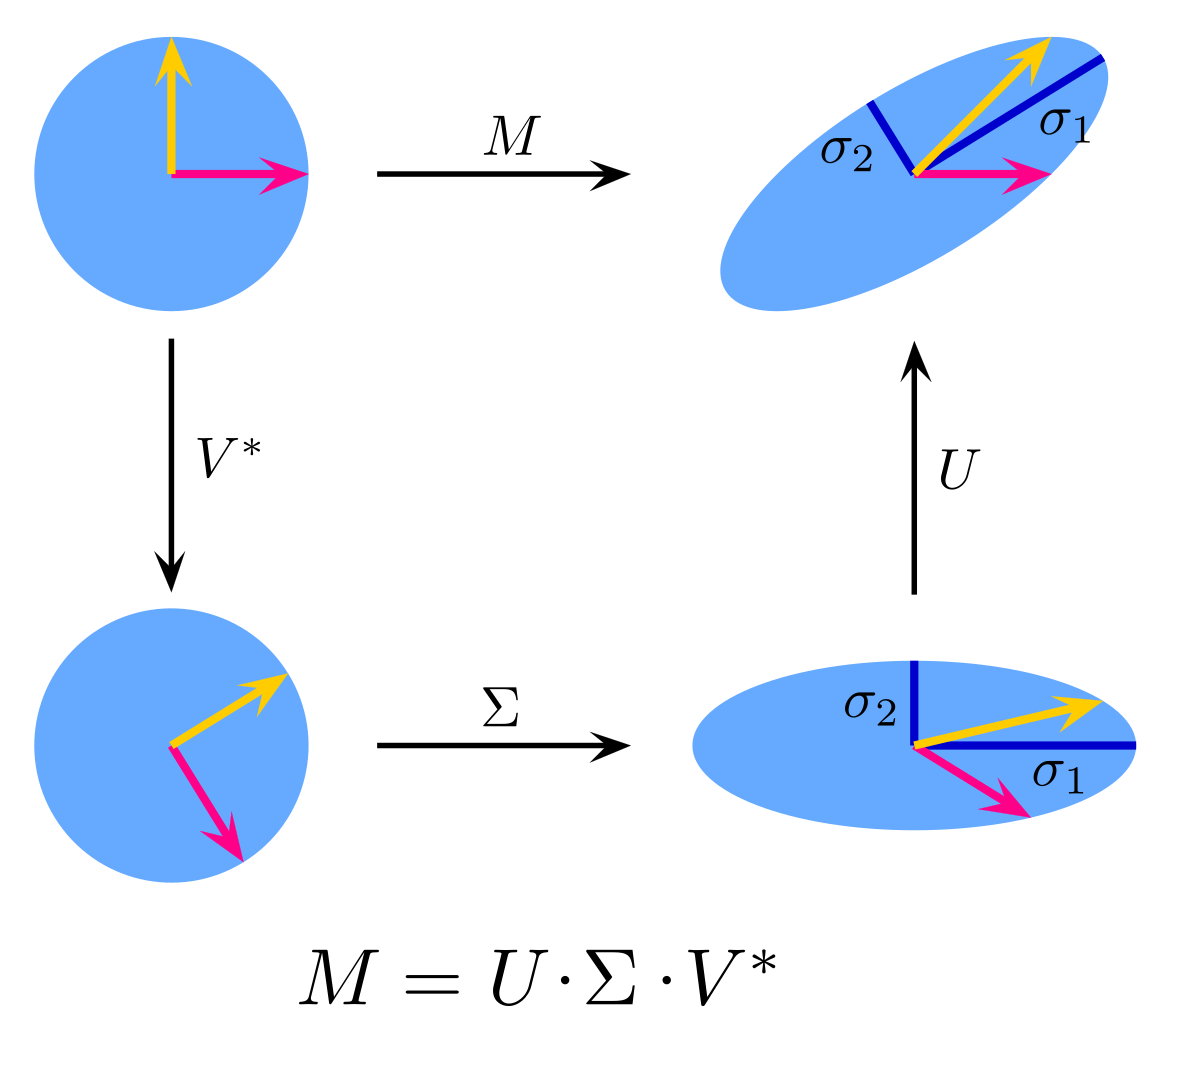

## Using SVD without hyperparameter tuning.

In [21]:
# Loading as Surprise dataframe
train_copy = df_train.copy()
reader = Reader()
# Data selected for model training
data = Dataset.load_from_df(train_copy[['userId', 'movieId', 'rating']], reader)

In [22]:
# Data split 99/1
trainset, testset = train_test_split(data, test_size=0.01)

In [23]:
train_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000038 entries, 0 to 10000037
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   timestamp  int64  
dtypes: float64(1), int64(3)
memory usage: 305.2 MB


## Training and Fitting the model

In [24]:
svd_model = SVD()

In [25]:
svd_model.fit(trainset)

In [26]:
# Making predictions using the testset
predictions = svd_model.test(testset) 
predictions

test = pd.DataFrame(predictions)

In [48]:
test.head()

,uid,iid,r_ui,est,details
0,11646,5378,4.0,3.922982,{'was_impossible': False}
1,49809,4226,4.0,4.307851,{'was_impossible': False}
2,137544,288,3.0,3.349603,{'was_impossible': False}
3,55263,454,5.0,4.161782,{'was_impossible': False}
4,105575,114180,5.0,3.831887,{'was_impossible': False}


In [51]:
# We are trying to predict ratings for every userId / movieId pair, we implement the below list comprehension to achieve this.
ratings_predictions=[svd_model.predict(row.userId, row.movieId) for _,row in df_test.iterrows()]
ratings_predictions

[Prediction(uid=1, iid=2011, r_ui=None, est=3.2869408969565113, details={'was_impossible': False}),
 Prediction(uid=1, iid=4144, r_ui=None, est=4.354662135006187, details={'was_impossible': False}),
 Prediction(uid=1, iid=5767, r_ui=None, est=3.835789627998257, details={'was_impossible': False}),
 Prediction(uid=1, iid=6711, r_ui=None, est=3.856459992879428, details={'was_impossible': False}),
 Prediction(uid=1, iid=7318, r_ui=None, est=2.759904158841757, details={'was_impossible': False}),
 Prediction(uid=1, iid=8405, r_ui=None, est=3.9399196671623278, details={'was_impossible': False}),
 Prediction(uid=1, iid=8786, r_ui=None, est=4.0084114537923385, details={'was_impossible': False}),
 Prediction(uid=2, iid=150, r_ui=None, est=3.629278521632265, details={'was_impossible': False}),
 Prediction(uid=2, iid=356, r_ui=None, est=3.3621202675696535, details={'was_impossible': False}),
 Prediction(uid=2, iid=497, r_ui=None, est=3.6217975314817843, details={'was_impossible': False}),
 Predict

In [63]:
# Converting our prediction into a Dataframe
df_pred=pd.DataFrame(ratings_predictions)
df_pred

,uid,iid,r_ui,est,details
0,1,2011,None,3.286941,{'was_impossible': False}
1,1,4144,None,4.354662,{'was_impossible': False}
2,1,5767,None,3.835790,{'was_impossible': False}
3,1,6711,None,3.856460,{'was_impossible': False}
4,1,7318,None,2.759904,{'was_impossible': False}
...,...,...,...,...,...
5000014,162541,4079,None,3.427132,{'was_impossible': False}
5000015,162541,4467,None,3.829274,{'was_impossible': False}
5000016,162541,4980,None,2.738565,{'was_impossible': False}
5000017,162541,5689,None,2.870142,{'was_impossible': False}


In [64]:
# Renaming our predictions to original names
df_pred=df_pred.rename(columns={'uid':'userId', 'iid':'movieId','est':'rating'})
df_pred.drop(['r_ui','details'],axis=1,inplace=True)

In [65]:
df_pred.head()

,userId,movieId,rating
0,1,2011,3.286941
1,1,4144,4.354662
2,1,5767,3.835790
3,1,6711,3.856460
4,1,7318,2.759904


In [66]:
# Concatenating userId/movieId into a single Id column
# Need to run this code more than once to improve the outcome
for i in range(2):
    df_pred['Id']=df_pred.apply(lambda x:'%s_%s' % (x['userId'],x['movieId']),axis=1)

In [67]:
# View the first five rows of the dataframe
df_pred.head(5)

,userId,movieId,rating,Id
0,1,2011,3.286941,1_2011
1,1,4144,4.354662,1_4144
2,1,5767,3.835790,1_5767
3,1,6711,3.856460,1_6711
4,1,7318,2.759904,1_7318


In [68]:
# Drop the columns: 'userId' and 'movieId'
df_pred.drop(['userId', 'movieId'], inplace=True, axis= 1)

In [69]:
# View the predicted dataset
df_pred = df_pred[['Id', 'rating']]

In [70]:
# View the first 5 rows
df_pred.head(5)

,Id,rating
0,1_2011,3.286941
1,1_4144,4.354662
2,1_5767,3.835790
3,1_6711,3.856460
4,1_7318,2.759904


In [71]:
# View the shape of the dataset to be submitted 
df_pred.shape

(5000019, 2)

In [72]:
# Submission csv file using svd model
df_pred.to_csv("svd_model.csv", index=False)

## Using SVD with hyperparameter tuning.

Tuning Parameters of the SVD model

In [7]:
# Loading as Surprise dataframe
train_copy = df_train.copy()
reader = Reader(rating_scale=(0, 5))
# Data for training the SVD model
data = Dataset.load_from_df(train_copy[['userId', 'movieId', 'rating']], reader)

## Training and Fitting the model

In [8]:
# The full dataset for model training
sup_train = data.build_full_trainset()
# The parameters obtained from randomised search CV
svd_model = SVD(n_factors = 300 , lr_all = 0.006 , reg_all = 0.04 , n_epochs = 60 , init_std_dev = 0.04)
# Fit the model
svd_model.fit(sup_train)

In [10]:
# We are trying to predict ratings for every userId / movieId pair, we implement the below list comprehension to achieve this.
ratings_predictions=[svd_model.predict(row.userId, row.movieId) for _,row in df_test.iterrows()]
# View the predictions
ratings_predictions

[Prediction(uid=1, iid=2011, r_ui=None, est=3.1516363309661704, details={'was_impossible': False}),
 Prediction(uid=1, iid=4144, r_ui=None, est=4.185356636885857, details={'was_impossible': False}),
 Prediction(uid=1, iid=5767, r_ui=None, est=3.7081362144893655, details={'was_impossible': False}),
 Prediction(uid=1, iid=6711, r_ui=None, est=4.137784653078555, details={'was_impossible': False}),
 Prediction(uid=1, iid=7318, r_ui=None, est=2.987135856643063, details={'was_impossible': False}),
 Prediction(uid=1, iid=8405, r_ui=None, est=3.8909590598219923, details={'was_impossible': False}),
 Prediction(uid=1, iid=8786, r_ui=None, est=3.892449646038255, details={'was_impossible': False}),
 Prediction(uid=2, iid=150, r_ui=None, est=3.7222361795287418, details={'was_impossible': False}),
 Prediction(uid=2, iid=356, r_ui=None, est=3.059849379114641, details={'was_impossible': False}),
 Prediction(uid=2, iid=497, r_ui=None, est=3.438429603548286, details={'was_impossible': False}),
 Predicti

In [11]:
# Converting our prediction into a familiar format-Dataframe
df_pred=pd.DataFrame(ratings_predictions)
# View the predictions from a dataframe
df_pred

,uid,iid,r_ui,est,details
0,1,2011,None,3.151636,{'was_impossible': False}
1,1,4144,None,4.185357,{'was_impossible': False}
2,1,5767,None,3.708136,{'was_impossible': False}
3,1,6711,None,4.137785,{'was_impossible': False}
4,1,7318,None,2.987136,{'was_impossible': False}
...,...,...,...,...,...
5000014,162541,4079,None,3.784658,{'was_impossible': False}
5000015,162541,4467,None,3.959883,{'was_impossible': False}
5000016,162541,4980,None,2.625446,{'was_impossible': False}
5000017,162541,5689,None,3.029278,{'was_impossible': False}


In [12]:
# Renaming our predictions to original names
df_pred=df_pred.rename(columns={'uid':'userId', 'iid':'movieId','est':'rating'})
# Drop the columns not required for the submission
df_pred.drop(['r_ui','details'],axis=1,inplace=True)

In [13]:
# Snippet of our ratings
df_pred.head(10)

,userId,movieId,rating
0,1,2011,3.151636
1,1,4144,4.185357
2,1,5767,3.708136
3,1,6711,4.137785
4,1,7318,2.987136
5,1,8405,3.890959
6,1,8786,3.892450
7,2,150,3.722236
8,2,356,3.059849
9,2,497,3.438430


In [14]:
# Concatenating userId/movieId into a single Id column
# Need to run this code more than once to improve the outcome
for i in range(2):
    df_pred['Id']=df_pred.apply(lambda x:'%s_%s' % (x['userId'],x['movieId']),axis=1)

In [15]:
# View the top 5 rows for the prediction
df_pred.head(5)

,userId,movieId,rating,Id
0,1,2011,3.151636,1_2011
1,1,4144,4.185357,1_4144
2,1,5767,3.708136,1_5767
3,1,6711,4.137785,1_6711
4,1,7318,2.987136,1_7318


In [16]:
# Drop the features that will not be required for the submission
df_pred.drop(['userId', 'movieId'], inplace=True, axis= 1)

In [17]:
# Datframe that will be ready for submission
df_pred = df_pred[['Id', 'rating']]

In [18]:
# View the first 5 rows 
df_pred.head(5)

,Id,rating
0,1_2011,3.151636
1,1_4144,4.185357
2,1_5767,3.708136
3,1_6711,4.137785
4,1_7318,2.987136


In [19]:
# Shape of the prediction dataset
df_pred.shape

(5000019, 2)

In [21]:
# Submission final csv. file
df_pred.to_csv("SVD_hyperparamters.csv", index=False)

In [ ]:
# Must install ploty
# conda install -c plotly plotly=5.1.0